In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys
sys.path.insert(1, "../..")
from simulations import van_der_pol_oscillator
from itertools import product
from prototype_nn import Splitting, predictions, tensor_flatten
import matplotlib.pyplot as plt
import torch
%run ../utilities.ipynb

## Training set : Simulations

## Dataframes

This is the simulations we use for training. The initial parameters x,y are within set [1,2,3,45]

In [2]:
training = pd.DataFrame(data = pd.read_csv("../../data/train/van.csv"))
training.head()

,time,x,y,initial_x,initial_y
0,0.000,1.000000,1.000000,1,1
1,0.001,1.000999,0.998999,1,1
2,0.002,1.001998,0.997996,1,1
3,0.003,1.002995,0.996991,1,1
4,0.004,1.003992,0.995984,1,1


In [3]:
len(training)

321600

This is to zip the initial parameters columns together

In [4]:
training["initial_parameters"] = list(zip(training.initial_x, training.initial_y))
training.head()

,time,x,y,initial_x,initial_y,initial_parameters
0,0.000,1.000000,1.000000,1,1,"(1, 1)"
1,0.001,1.000999,0.998999,1,1,"(1, 1)"
2,0.002,1.001998,0.997996,1,1,"(1, 1)"
3,0.003,1.002995,0.996991,1,1,"(1, 1)"
4,0.004,1.003992,0.995984,1,1,"(1, 1)"


This allows you to get the simulations where the initial parameters are x = 1, y = 1

In [5]:
initial_x1y1 = training[training["initial_parameters"] == (1,1)]

This would plots the graphs of inital parameters x = 1 , y = 1

<AxesSubplot:xlabel='time', ylabel='y'>

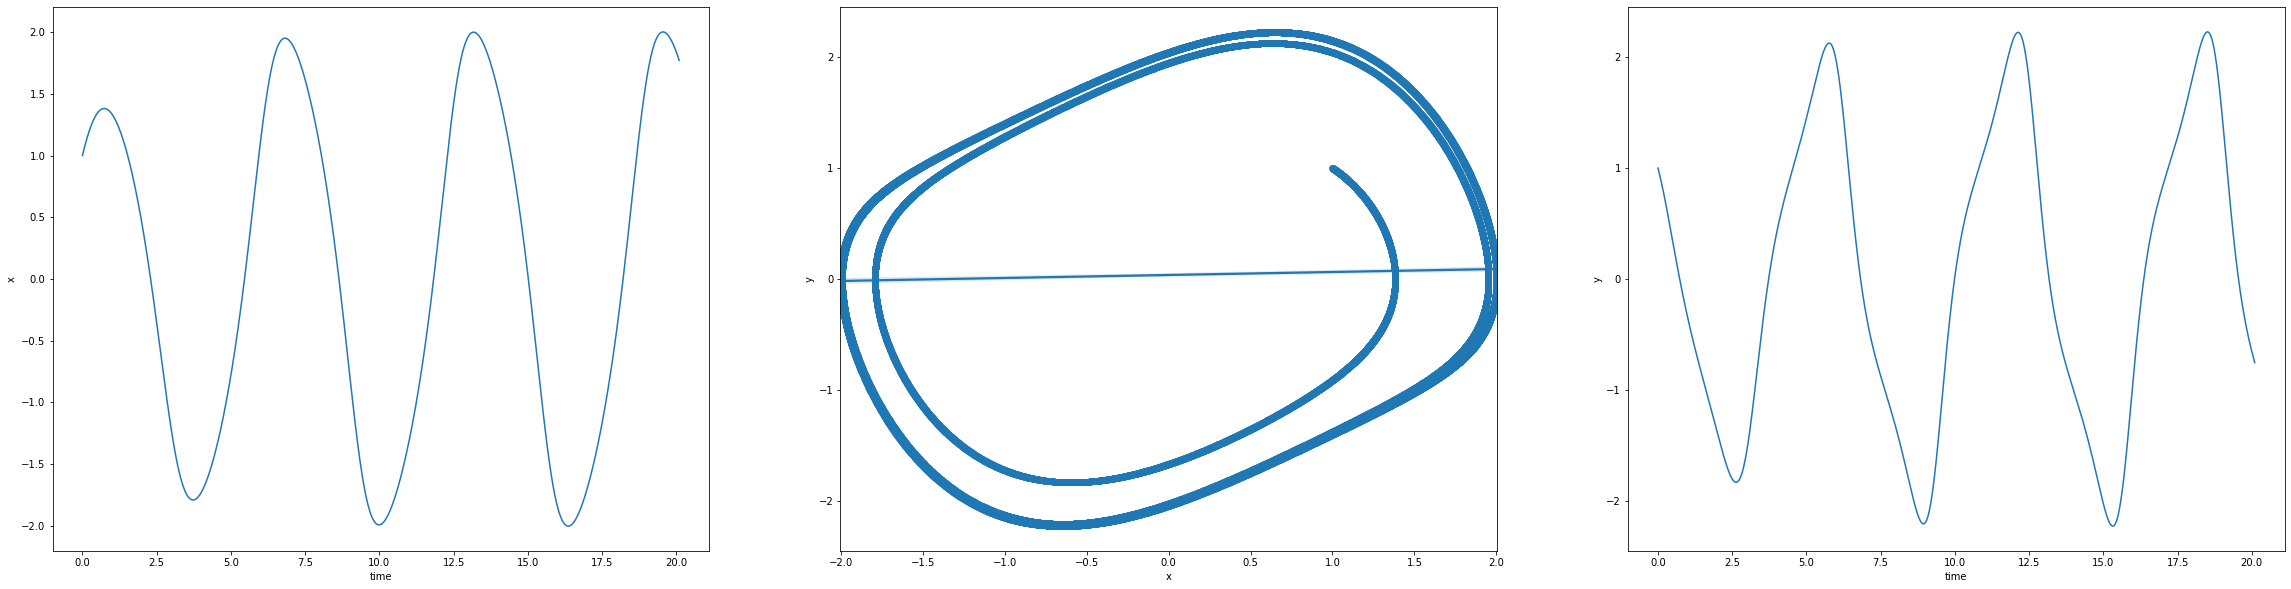

In [6]:
fig, ax = plt.subplots(ncols=3, figsize=(40,10))
sns.lineplot(data = initial_x1y1, x = "time", y = "x", ax=ax[0])
sns.regplot(data=initial_x1y1, x="x", y="y", ax=ax[1])
sns.lineplot(data = initial_x1y1, x = "time", y = "y", ax=ax[2])

## Cross validation

This is applying cross validation to our training data

In [62]:
# lr = 0.0001, bs = 15, ts = 15, epoch = 50
kfold = Splitting([0,3,4], [1,2], num_epoches = 20, batch_size = 32, lr= 0.00001)

In [ ]:
evaluate = kfold.cross_validation_evaluate(training, 5)

------------- Fold 0 -------------
TEST: 0 TRAIN: [1, 2, 3, 4]
Epoch: 0  Train Loss: 1.4208863973617554 
Epoch: 1  Train Loss: 1.348236083984375 
Epoch: 2  Train Loss: 1.3198518753051758 
Epoch: 3  Train Loss: 1.247514009475708 
Epoch: 4  Train Loss: 0.5578887462615967 
Epoch: 5  Train Loss: 0.6039469838142395 
Epoch: 6  Train Loss: 0.5462912917137146 
Epoch: 7  Train Loss: 0.792505145072937 
Epoch: 8  Train Loss: 0.34403327107429504 
Epoch: 9  Train Loss: 0.30851471424102783 
Epoch: 10  Train Loss: 0.11517158895730972 
Epoch: 11  Train Loss: 0.2258167266845703 
Epoch: 12  Train Loss: 0.05869479104876518 
Epoch: 13  Train Loss: 0.03177453577518463 
Epoch: 14  Train Loss: 0.030222054570913315 
Epoch: 15  Train Loss: 0.006974079646170139 
Epoch: 16  Train Loss: 0.020275916904211044 
Epoch: 17  Train Loss: 0.02632710710167885 
Epoch: 18  Train Loss: 0.01822817511856556 
Epoch: 19  Train Loss: 0.006948888301849365 
------------- Fold 1 -------------
TEST: 1 TRAIN: [0, 2, 3, 4]
Epoch: 0  Tr

This is the evaluatons from the cross validation

In [ ]:
evaluate

Measures the average of the evaluations

In [ ]:
average_loss = 0
for x in evaluate:
    average_loss += x.item()
average_loss/len(evaluate)

## Training Data : Predictions

This loads the predictions of the training data.

In [7]:
training_preds = pd.DataFrame(data = pd.read_csv("../../data/preds/train/van.csv"))
training_preds.head()

,time,initial_x,initial_y,x,y
0,0.000,1,1,0.878540,1.075928
1,0.001,1,1,0.880194,1.073958
2,0.002,1,1,0.881844,1.071989
3,0.003,1,1,0.883496,1.070020
4,0.004,1,1,0.885149,1.068051


This manipulate the "training_preds" dataframes (we drop columns, and rename some columns) to be later used for plotting graphs

In [8]:
training_preds = training_preds.drop(columns = ["initial_x", "initial_y", "time"])
training_preds = training_preds.rename(columns={
                                            'x' : 'x_preds',
                                            'y' : 'y_preds'})

This shows the first 4 rows of the training predictions.

In [9]:
training_preds.head()

,x_preds,y_preds
0,0.878540,1.075928
1,0.880194,1.073958
2,0.881844,1.071989
3,0.883496,1.070020
4,0.885149,1.068051


This combines the training data and predictions dataframe together

In [10]:
training_and_predictions = pd.merge(training, training_preds, right_index=True, left_index=True)

This is the first 5 rows within the dataframes 

In [11]:
training_and_predictions.head()

,time,x,y,initial_x,initial_y,initial_parameters,x_preds,y_preds
0,0.000,1.000000,1.000000,1,1,"(1, 1)",0.878540,1.075928
1,0.001,1.000999,0.998999,1,1,"(1, 1)",0.880194,1.073958
2,0.002,1.001998,0.997996,1,1,"(1, 1)",0.881844,1.071989
3,0.003,1.002995,0.996991,1,1,"(1, 1)",0.883496,1.070020
4,0.004,1.003992,0.995984,1,1,"(1, 1)",0.885149,1.068051


This function is defined to be later used for plotting graphs

In [12]:
def hue(df, hue):
    for var in hue:
        columns = list(df.columns)
        columns.remove(var)
        columns.remove("{}_{}".format(var,"preds"))
        df = df.melt(columns, var_name=var, value_name = f"{var}value")
    return df

## Graphs

Looking at training simulations compared to the predictions. This produces a high results

In [13]:
def plot(x, y,**kwargs):
    plt.plot(x,y)

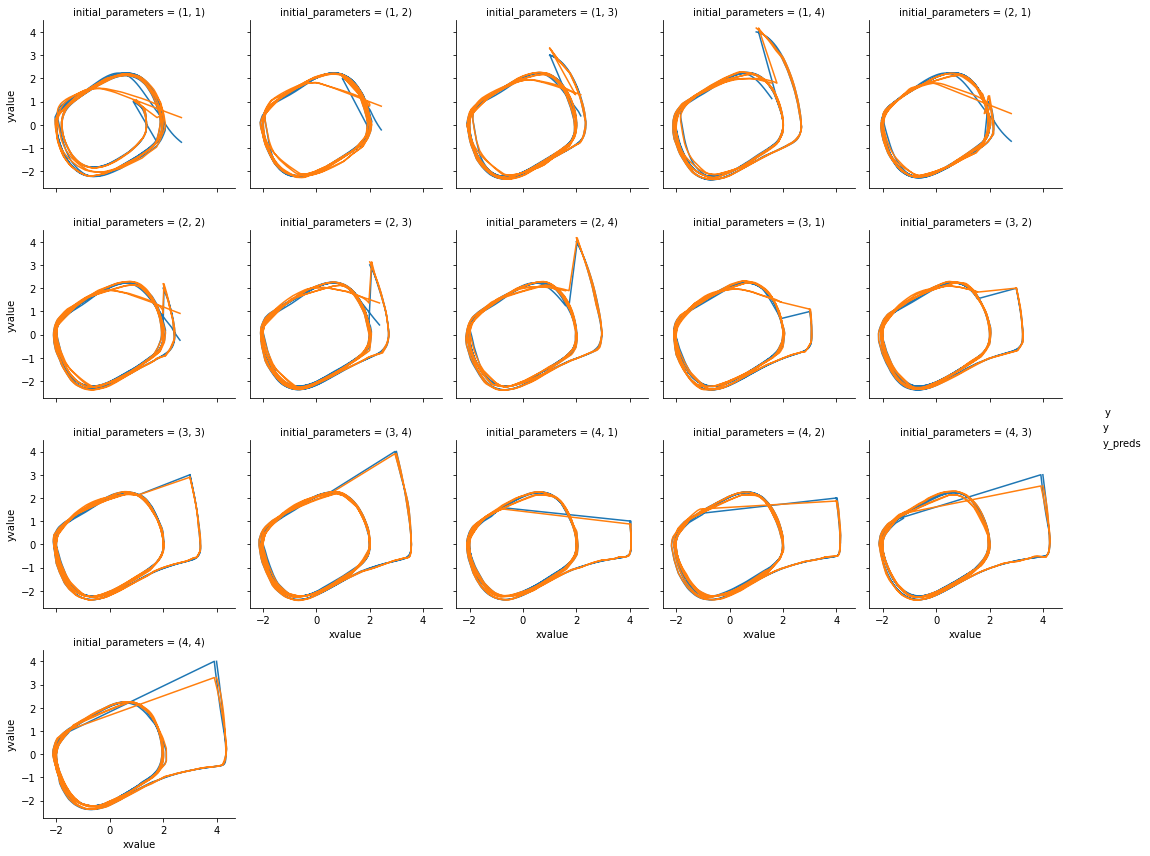

In [14]:
g = sns.FacetGrid(hue(training_and_predictions, ["x", "y"]), col="initial_parameters", hue="y", col_wrap=5,)
g.map(plot, "xvalue", "yvalue", ci=None)
g.add_legend()

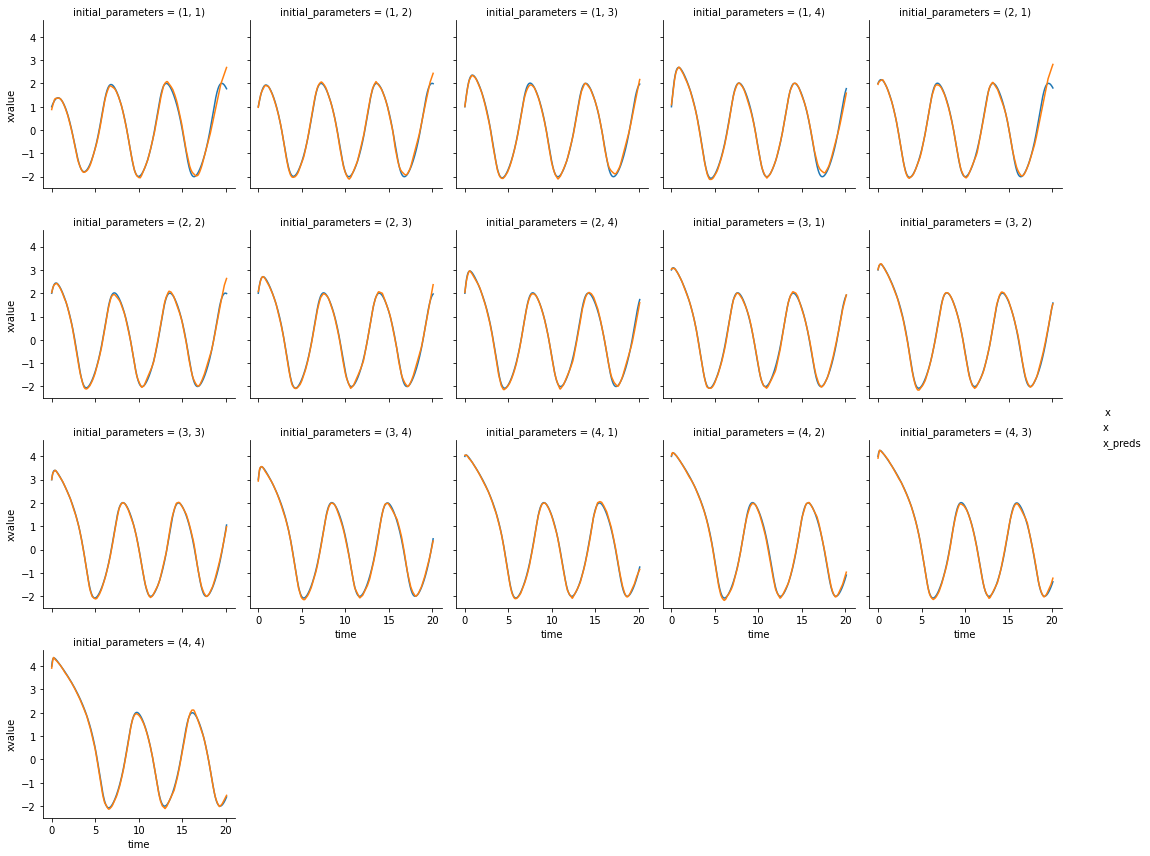

In [15]:
g = sns.FacetGrid(hue(training_and_predictions, ["x"]), col="initial_parameters", hue="x", col_wrap=5,)
g.map(plot, "time", "xvalue", ci=None)
g.add_legend()

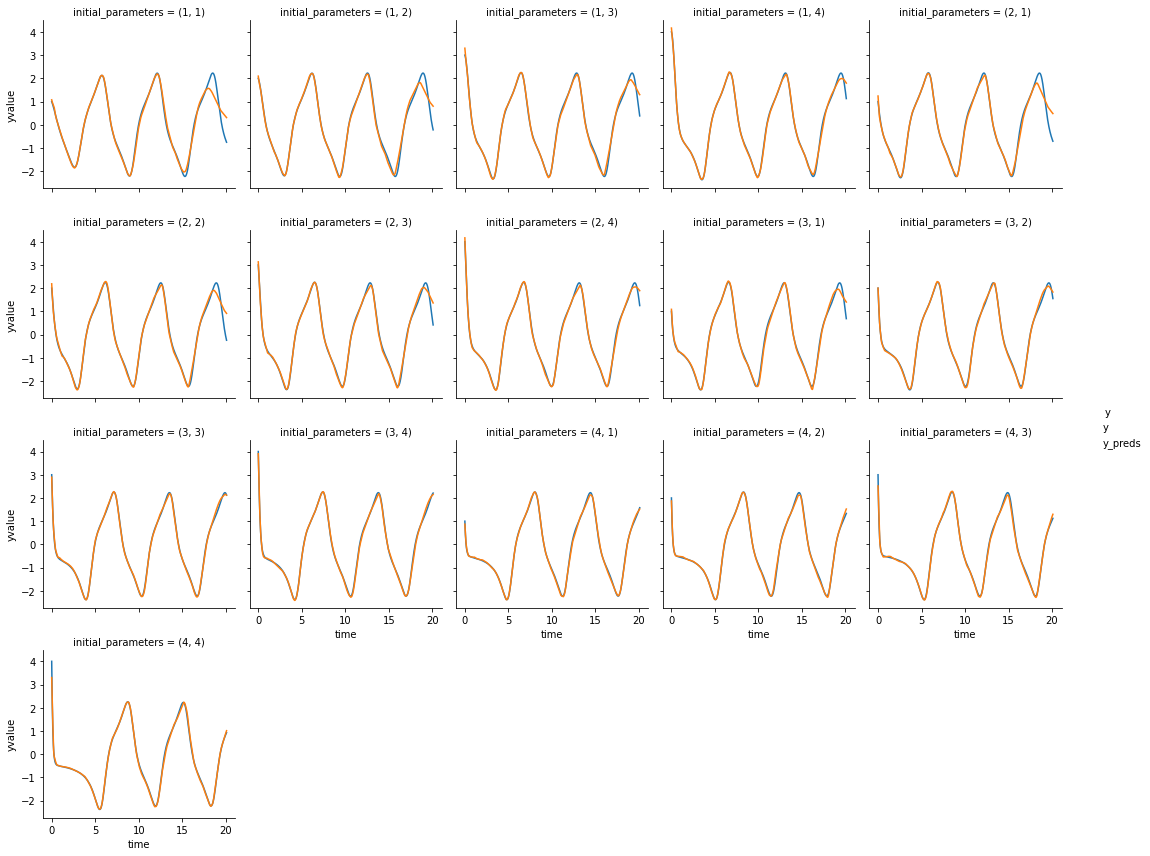

In [16]:
g = sns.FacetGrid(hue(training_and_predictions, ["y"]), col="initial_parameters", hue="y", col_wrap=5,)
g.map(plot, "time", "yvalue", ci=None)
g.add_legend()

## Testing : Simulations

This is produces simulations which will now be used as testing data. Where we have initial parameters in set [5,6]

In [17]:
testing = van_der_pol_oscillator(delta = 0.001, simulations = 20.1, save = False, initial_paras = np.round(np.random.uniform(0, 5, 4), 2))

This puts the inital parameters columns into one column as tuple

In [18]:
testing["initial_parameters"] = list(zip(testing.initial_x, testing.initial_y))
testing.head()

,time,x,y,initial_x,initial_y,initial_parameters
0,0.000,0.06000,0.060000,0.06,0.06,"(0.06, 0.06)"
1,0.001,0.06006,0.059970,0.06,0.06,"(0.06, 0.06)"
2,0.002,0.06012,0.059940,0.06,0.06,"(0.06, 0.06)"
3,0.003,0.06018,0.059909,0.06,0.06,"(0.06, 0.06)"
4,0.004,0.06024,0.059879,0.06,0.06,"(0.06, 0.06)"


In [19]:
len(testing)

321600

## Testing : Predictions

This will be used for getting the predictions of the testing data

In [20]:
def testing_preds(test_df):
    inputs = torch.tensor(test_df.iloc[ :, [0,3,4]].values)
    targets = torch.tensor(test_df.iloc[:, [1,2]].values)
    preds, _ = predictions(num_inputs=3, num_classes=2, learning_rate=0.0005, batch_size=1, num_epochs=1, inputs=inputs.float(), targets=targets.float(), train=False, path= "../../data/state/van.pth")
    data = {'time' : test_df.time.values,
            'initial_parameters' : test_df.initial_parameters.values,
            'x' : tensor_flatten(preds[:,0]), 'y' : tensor_flatten(preds[:, 1])}
    return pd.DataFrame(data = data, columns = ["time", "x", "y", "initial_parameters"]);

In [21]:
testing_preds = testing_preds(testing)

In [22]:
len(testing_preds)

321600

In [23]:
testing_preds.head()

,time,x,y,initial_parameters
0,0.000,0.226662,0.436587,"(0.06, 0.06)"
1,0.001,0.228084,0.436070,"(0.06, 0.06)"
2,0.002,0.229505,0.435553,"(0.06, 0.06)"
3,0.003,0.230920,0.435036,"(0.06, 0.06)"
4,0.004,0.232334,0.434523,"(0.06, 0.06)"


This is manipulating the dataframes, for it to be later used in plotting graphs

In [24]:
testing_preds = testing_preds.rename(columns={"x" : "x_preds", "y" : "y_preds"})

In [25]:
testing_and_predictions = pd.merge(testing, testing_preds, right_on=["time", "initial_parameters"], left_on=["time", "initial_parameters"])

In [26]:
testing_and_predictions.head()

,time,x,y,initial_x,initial_y,initial_parameters,x_preds,y_preds
0,0.000,0.06000,0.060000,0.06,0.06,"(0.06, 0.06)",0.226662,0.436587
1,0.001,0.06006,0.059970,0.06,0.06,"(0.06, 0.06)",0.228084,0.436070
2,0.002,0.06012,0.059940,0.06,0.06,"(0.06, 0.06)",0.229505,0.435553
3,0.003,0.06018,0.059909,0.06,0.06,"(0.06, 0.06)",0.230920,0.435036
4,0.004,0.06024,0.059879,0.06,0.06,"(0.06, 0.06)",0.232334,0.434523


## Graphs

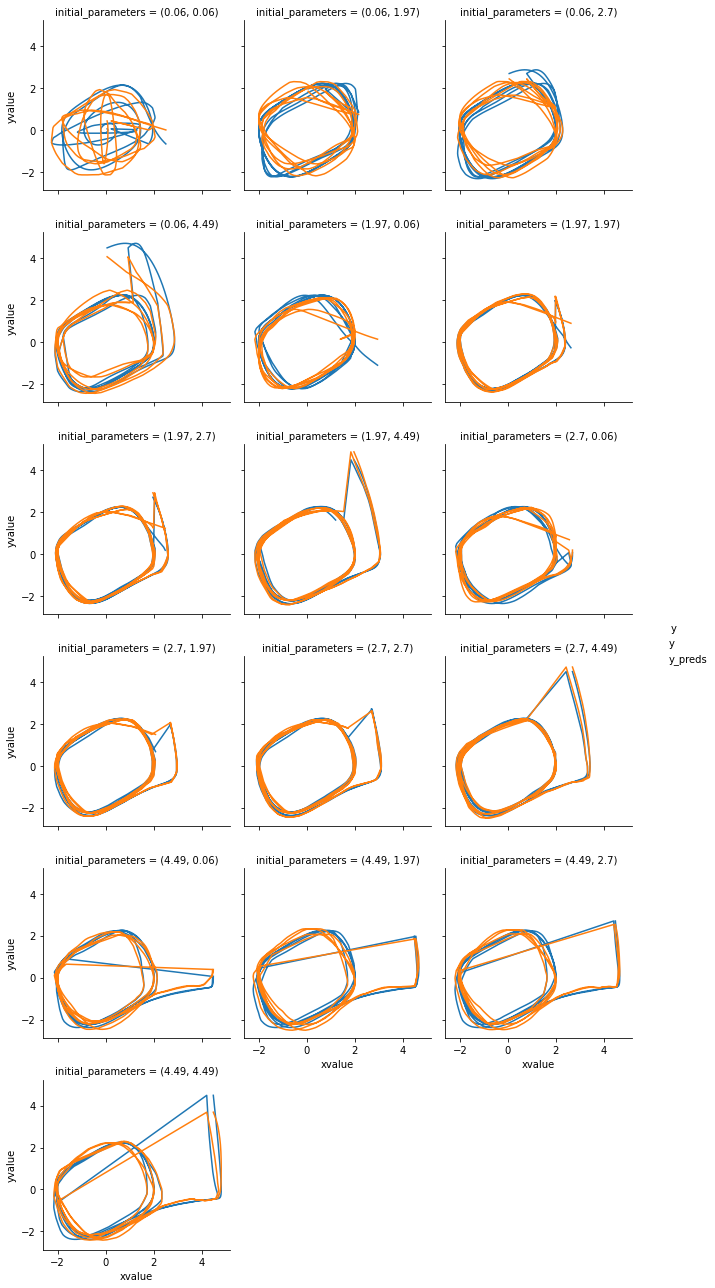

In [27]:
g = sns.FacetGrid(hue(testing_and_predictions, ["x", "y"]), col_wrap=3, col="initial_parameters", hue="y")
g.map(plot, "xvalue", "yvalue", ci=None)
g.add_legend()

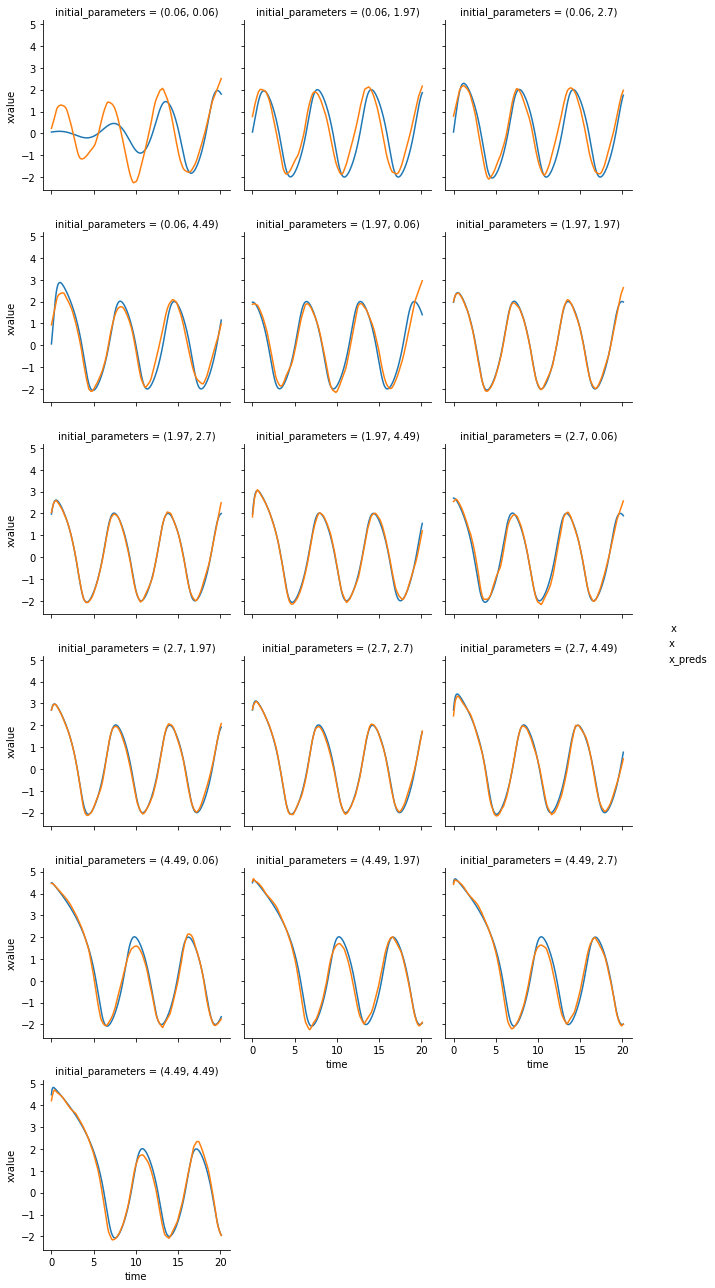

In [28]:
g = sns.FacetGrid(hue(testing_and_predictions, ["x"]), col_wrap=3, col="initial_parameters", hue="x",)
g.map(plot, "time", "xvalue", ci=None)
g.add_legend()

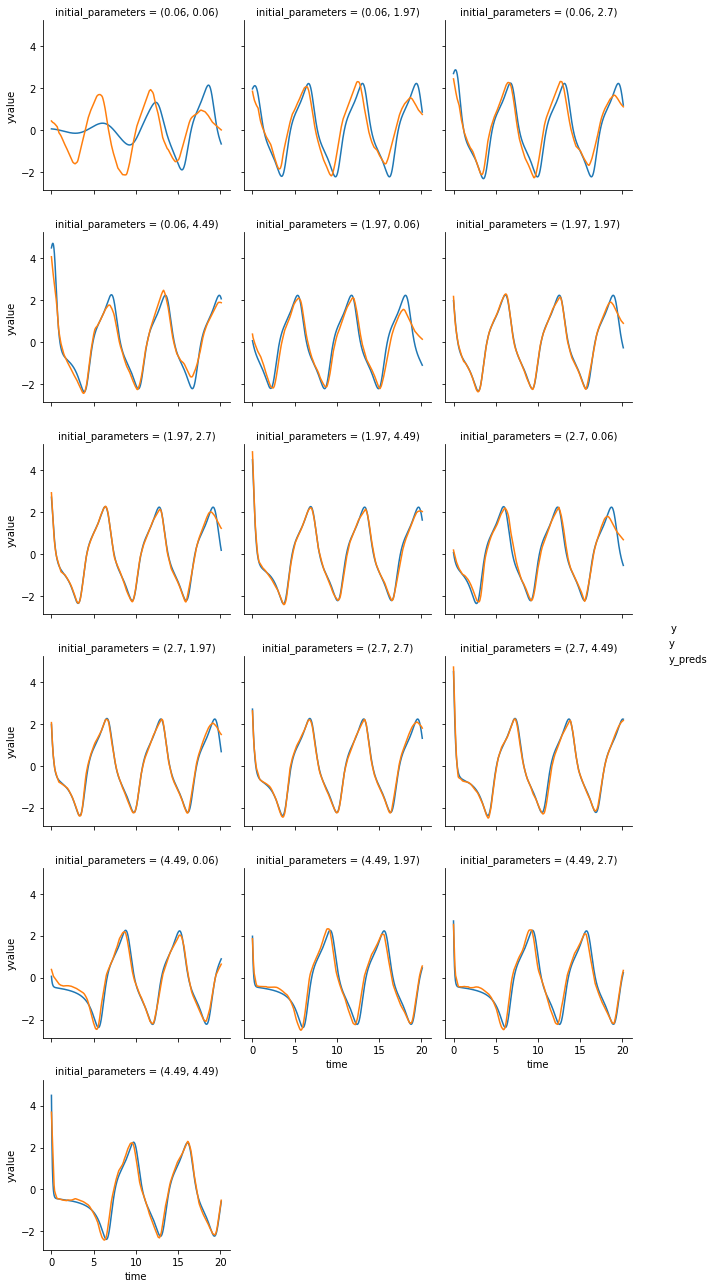

In [29]:
g = sns.FacetGrid(hue(testing_and_predictions, ["y"]), col_wrap=3, col="initial_parameters", hue="y")
g.map(plot, "time", "yvalue", ci=None)
g.add_legend()

### Loss my simulations

This is section is demonstrating how the loss changes for a certain individual.

Below is the dataframes we are using:
    <ol>
    <li> testing - the simulations testing data </li>
    <li> testing_predictions - the predictions of the simulation testing data </li>
    </ol>

In [30]:
testing.head()

,time,x,y,initial_x,initial_y,initial_parameters
0,0.000,0.06000,0.060000,0.06,0.06,"(0.06, 0.06)"
1,0.001,0.06006,0.059970,0.06,0.06,"(0.06, 0.06)"
2,0.002,0.06012,0.059940,0.06,0.06,"(0.06, 0.06)"
3,0.003,0.06018,0.059909,0.06,0.06,"(0.06, 0.06)"
4,0.004,0.06024,0.059879,0.06,0.06,"(0.06, 0.06)"


In [31]:
testing_preds.head()

,time,x_preds,y_preds,initial_parameters
0,0.000,0.226662,0.436587,"(0.06, 0.06)"
1,0.001,0.228084,0.436070,"(0.06, 0.06)"
2,0.002,0.229505,0.435553,"(0.06, 0.06)"
3,0.003,0.230920,0.435036,"(0.06, 0.06)"
4,0.004,0.232334,0.434523,"(0.06, 0.06)"


This is the lossBySimulation function. This provides us with the loss for each simulatin

In [45]:
simulationLoss, _ = lossBySimulations(testing, testing_preds, [1,2])

This is the simulationLoss dataframe, showing the inital parameters (simulation) and the corresponding loss

In [46]:
simulationLoss.head()

,initial_parameters,Loss
0,0.06 0.06,0.665531
1,0.06 1.97,0.347407
2,0.06 2.7,0.219050
3,0.06 4.49,0.102628
4,1.97 0.06,0.137918


In [47]:
simulationLossDistance = lossBySimulationsDistance(simulationLoss, initial_values = [np.arange(1,5,1),np.arange(1,5,1)])

In [35]:
simulationLossDistance.head()

,initial_parameters,Loss,Distance
10,2.7 2.7,0.008062,0.244949
6,1.97 2.7,0.010969,0.490586
9,2.7 1.97,0.011921,0.490586
5,1.97 1.97,0.016798,0.649115
11,2.7 4.49,0.012713,1.732072


This is a bar box plot of that simulation

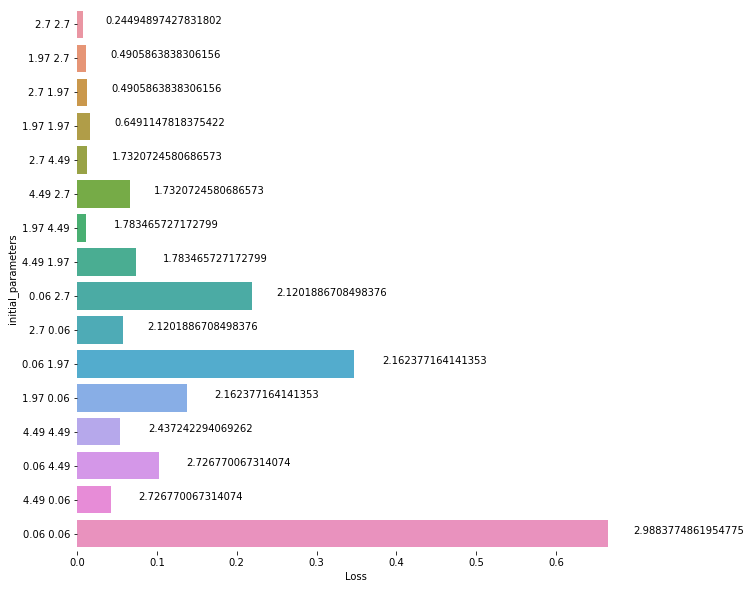

In [51]:
simulaPlots("Loss", "initial_parameters", simulationLossDistance, figsize = (10,10), pos = 0.1)

<AxesSubplot:>

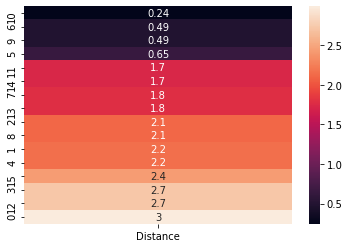

In [61]:
sns.heatmap(simulationLossDistance[["Distance"]], annot=True)

The lossByTime function would provide a loss for a specfic time for a certain simulation

In [53]:
timeLoss, _ = lossByTime(testing, testing_preds, [1,2])

The timeLoss now holds the loss corresponding to a specific time for a intial_parameter (simulation). This is demonstrated below

In [54]:
timeLoss.head()

,Time,initial_parameters,Loss
0,0.000,"(0.06, 0.06)",0.084797
1,0.001,"(0.06, 0.06)",0.084842
2,0.002,"(0.06, 0.06)",0.084888
3,0.003,"(0.06, 0.06)",0.084936
4,0.004,"(0.06, 0.06)",0.084987


In [55]:
individualTimeLoss = timeLoss.groupby("Time").sum("Loss").reset_index()

In [56]:
individualTimeLoss

,Time,Loss
0,0.000,1.820498
1,0.001,1.789151
2,0.002,1.759971
3,0.003,1.732719
4,0.004,1.707684
...,...,...
20095,20.095,5.760675
20096,20.096,5.776129
20097,20.097,5.791642
20098,20.098,5.807223


The graphs showning these plots

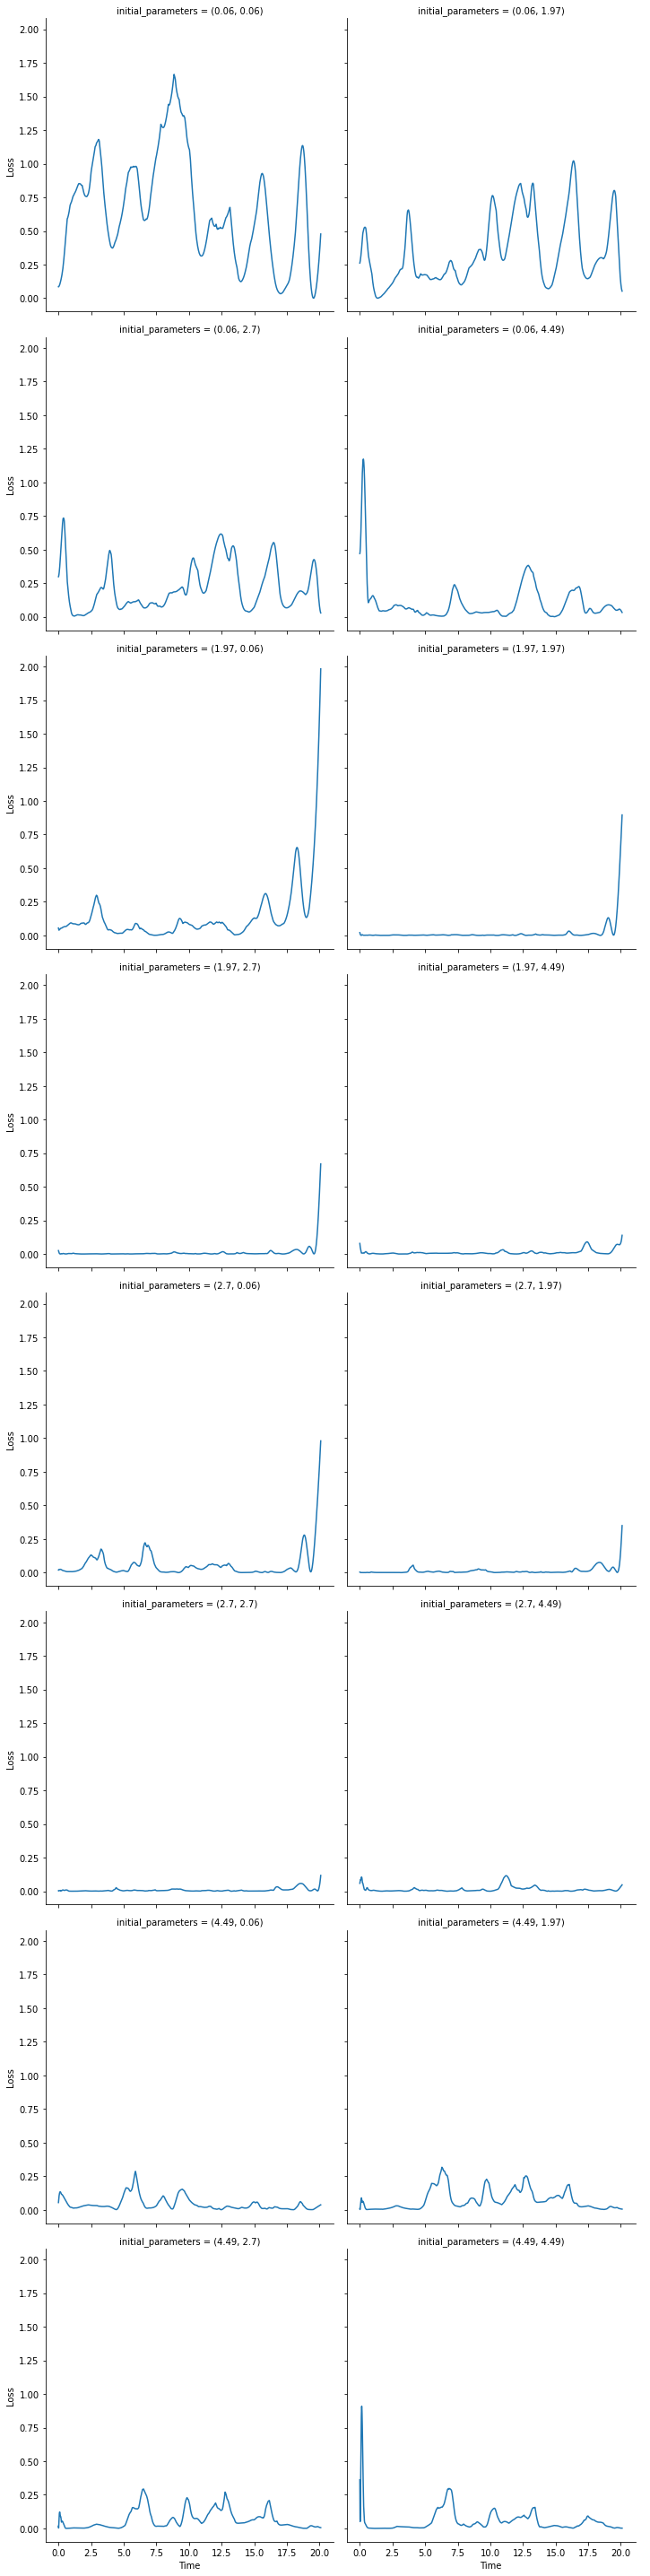

In [57]:
g = sns.FacetGrid(data = timeLoss, col = "initial_parameters", height = 5, col_wrap=2)
g.map(sns.lineplot, "Time", "Loss", ci=None)
g.add_legend()

<AxesSubplot:xlabel='Time', ylabel='Loss'>

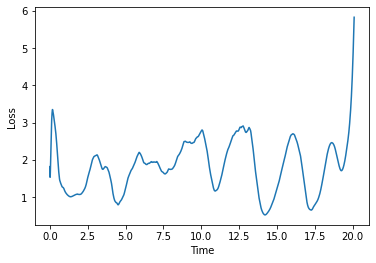

In [58]:
sns.lineplot(data = individualTimeLoss, x = "Time", y = "Loss")